In [1]:
%matplotlib inline

In [300]:
import itertools as it

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import GPy

Read in data, then convert the second level (i.e. index=1) from strings to floats.  This conversion ensures that columns are recognised as "sorted" and `.loc` slicing works as expected.

In [135]:
inp = pd.read_csv("ip2/csi/testdata/Demo_DREAM.csv",index_col=0,header=[0,1])

inp.columns = pd.MultiIndex.from_tuples(
    inp.columns.set_levels(level=1,
        levels=np.array(inp.columns.levels[1],dtype=float)),
    names=inp.columns.names)

In [153]:
inp.loc["Gene1",("T1",pd.IndexSlice[0:500])]

Treatment  Time
T1         0       0.709247
           50      0.227989
           100     0.080199
           150     0.007677
           200     0.004652
           250     0.003049
           300     0.000790
           350     0.000000
           400     0.002035
           450     0.002429
           500     0.005413
Name: Gene1, dtype: float64

I define `inpX` to be the inputs to the GP regressions and `inpY` the outputs.  Given time series upto $t$, `inpX` therefore contains indicies $1\dots t-1$ and `inpY` indicies $2\dots t$, i.e. both contain one less element than `inp`.

This is all somewhat complicated by the fact that we have replicates, I currently don't want to assume that every replicate has the same number of time points.  However, given the requirement that the time points are "evenly" spaced kind of implies that each replicate will always have exactly the same time points associated.

In [260]:
def getIndicies(x):
    """Returns indicies, [i], where item $x_i = x_{i-1}$."""
    prev = None
    for i, a in enumerate(x):
        if a == prev:
            yield i
        prev = a

ix = np.array(list(getIndicies([a for a,b in iter(inp.columns)])))
inpX = inp.iloc[slice(None),ix-1].T
inpY = inp.iloc[slice(None),ix].T

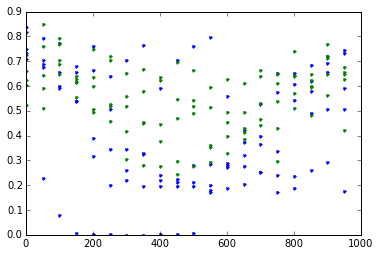

In [261]:
plt.plot([b for a,b in inpX.index],
         inpX[["Gene1","Gene2"]],'.');

GP_regression.,Value,Constraint,Prior,Tied to
rbf.variance,0.138479875126,+ve,,
rbf.lengthscale,0.289689314774,+ve,,
Gaussian_noise.variance,0.0277959330896,+ve,,


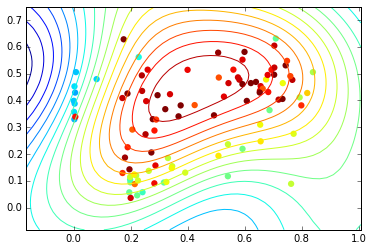

In [317]:
m = GPy.models.GPRegression(inpX[["Gene1","Gene3"]],inpY[["Gene10"]])
m.optimize()
m.plot();
m

In [325]:
def setup(itX, Y):
    for i in itX:
        yield GPy.models.GPRegression(inpX[list(i)],Y)

def optimise(it):
    for m in it:
        m.optimize()

In [326]:
%%time
p = list(it.combinations(np.delete(inp.index,9),2))

M = list(setup(iter(p), inpY[["Gene10"]]))

CPU times: user 250 ms, sys: 8.4 ms, total: 259 ms
Wall time: 254 ms


In [327]:
%%time
optimise(M)

CPU times: user 2.53 s, sys: 199 ms, total: 2.73 s
Wall time: 2.6 s


In [328]:
list(zip(p,[m.log_likelihood() for m in M]))

[(('Gene1', 'Gene2'), 8.0870538103791887),
 (('Gene1', 'Gene3'), 22.794313154360353),
 (('Gene1', 'Gene4'), 9.2536640695088295),
 (('Gene1', 'Gene5'), 10.056962023834942),
 (('Gene1', 'Gene6'), 4.1478895409346705),
 (('Gene1', 'Gene7'), 11.475301518658341),
 (('Gene1', 'Gene8'), 15.405475713926975),
 (('Gene1', 'Gene9'), 10.007246942195152),
 (('Gene2', 'Gene3'), 1.9197502193433706),
 (('Gene2', 'Gene4'), -3.6433678729564747),
 (('Gene2', 'Gene5'), 8.8110065555238037),
 (('Gene2', 'Gene6'), -4.0408349232513814),
 (('Gene2', 'Gene7'), -1.2914704776037809),
 (('Gene2', 'Gene8'), 1.8189851181074985),
 (('Gene2', 'Gene9'), -3.8320845239042711),
 (('Gene3', 'Gene4'), 0.34837002086636204),
 (('Gene3', 'Gene5'), 11.304059261937134),
 (('Gene3', 'Gene6'), -1.608746928745397),
 (('Gene3', 'Gene7'), -0.39009714017508657),
 (('Gene3', 'Gene8'), 1.5862187578956721),
 (('Gene3', 'Gene9'), -1.3362075799561737),
 (('Gene4', 'Gene5'), 7.7441518102530722),
 (('Gene4', 'Gene6'), -3.7820694996555417),
 (